## Resampling and the Bootstrap

Welcome to lab 7!

In textbook section [10.3](https://www.inferentialthinking.com/chapters/10/3/Empirical_Distribution_of_a_Statistic.html), we saw an example of *estimation*.  The British Royal Air Force wanted to know how many warplanes the Germans had (some number `N`, a *population parameter*), and they needed to estimate that quantity knowing only a random sample of the planes' serial numbers (from 1 to `N`).  For example, one estimate was twice the mean of the sample serial numbers.

We investigated the random variation in these estimates by simulating sampling from the population many times and computing estimates from each sample.  In real life, if the RAF had known what the population looked like, they would have known `N` and would not have had any reason to think about random sampling.  They didn't know what the population looked like, so they couldn't have run the simulations we did.  So that was useful as an exercise in *understanding random variation* in an estimate, but not as a tool for practical data analysis.

Now we'll flip that idea on its head to make it practical.  Given *just* a random sample of serial numbers, we'll estimate `N`, and then we'll use simulation to find out how accurate our estimate probably is, without ever looking at the whole population.  This is an example of *statistical inference*.

As usual, **run the cell below** to prepare the lab and the automatic tests.

In [1]:
# Run this cell to set up the notebook, but please don't change it.

# These lines import the Numpy and Datascience modules.
import numpy as np
from datascience import *

# These lines do some fancy plotting magic.
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import warnings
warnings.simplefilter('ignore', FutureWarning)

# These lines load the tests.
from client.api.notebook import Notebook
ok = Notebook('lab07.ok')
_ = ok.auth(inline=True)

Assignment: Resampling and the Bootstrap
OK, version v1.18.1



ERROR  | auth.py:102 | {'error': 'invalid_grant'}



Open the following URL:

https://okpy.org/client/login/

After logging in, copy the code from the web page and paste it into the box.
Then press the "Enter" key on your keyboard.

Paste your code here: WuZq62gkYGLhDI3IQsy2kgWl0BZyGb
Successfully logged in as a00344428@itesm.mx


## 1. Preliminaries
Remember the setup: We (the RAF in World War II) want to know the number of warplanes fielded by the Germans.  That number is `N`.  The warplanes have serial numbers from 1 to `N`, so `N` is also equal to the largest serial number on any of the warplanes.

We only see a small number of serial numbers (assumed to be a random sample with replacement from among all the serial numbers), so we have to use estimation.

#### Question 1.1
Is `N` a population parameter or a statistic?  If we compute a number using our random sample that's an estimate of `N`, is that a population parameter or a statistic?

N is a population parameter and an estimate is a statistic.

Check your answer with a neighbor or a TA.

To make the situation realistic, we're going to hide the true number of warplanes from you.  You'll have access only to this random sample:

In [2]:
observations = Table.read_table("serial_numbers.csv")
num_observations = observations.num_rows
observations

serial number
47
42
57
79
26
23
36
64
83
135


#### Question 1.2
Define a function named `plot_serial_numbers` to make a histogram of any table of serial numbers.  It should take one argument, a table like `observations` with one column called `"serial number"`.  It should plot a histogram of the values in the column **using bins of width 1** ranging from **1 to 200** but return nothing.  Then, call that function to make a histogram of `observations`.

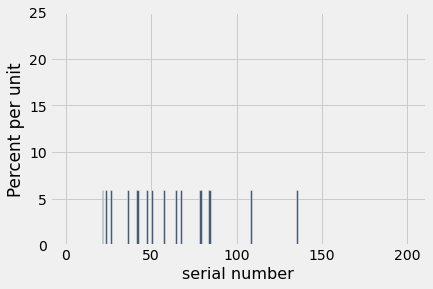

In [3]:
def plot_serial_numbers(numbers):
    numbers.hist(bins=np.arange(1, 200+2)) 
    
    # Assuming the lines above produce a histogram, this next
    # line may make your histograms look nicer.  Feel free to
    # delete it if you want.
    plt.ylim(0, .25)

plot_serial_numbers(observations)

#### Question 1.3
What does each little bar in the histogram represent and why are all the bars the same height?

Each bar represents one observed serial number. They are all the same height because there are not two equal numbers. 

#### Question 1.4
In the previous lab, we saw that one way to estimate `N` was to take twice the mean of the serial numbers we see. Write a function that computes that statistic.  It should take as its argument an array of serial numbers and return twice their mean.  Call it `mean_based_estimator`.  

After that, use it to compute an estimate of `N` called `mean_based_estimate`.

In [5]:
def mean_based_estimator(nums):
    return 2*np.average(nums)

mean_based_estimate = mean_based_estimator(observations.column(0))
mean_based_estimate

122.47058823529412

In [6]:
_ = ok.grade('q1_4')

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



#### Question 1.5
We also estimated `N` using the biggest serial number in the sample.  Compute it, giving it the name `max_estimate`.

In [7]:
max_estimate = max(observations.column(0))
max_estimate

135

In [8]:
_ = ok.grade('q1_5')

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



#### Question 1.6
Look at the values of `max_estimate` and `mean_based_estimate` that we happened to get for our dataset.  The value of `max_estimate` tells you something about `mean_based_estimate`.  Is it possible for `mean_based_estimate` to be equal to `N` (at least, if we round it to the nearest integer)?  If not, is it definitely higher, definitely lower, or can we not tell?  Can you make a statement like "`mean_based_estimate` is at least *[fill in a number]* away from `N`"?

Is not possible for mean_based_estimate to be equal to N. It is definitely lower. N.max_estimate can never be more than N, so N is at least 135, therefore mean_based_estimate is at least 11 away from N.

Check your answer with a neighbor or a TA.

We can't just confidently proclaim that `max_estimate` or `mean_based_estimate` is equal to `N`.  What if we're really far off?  So we want to get a sense of the accuracy of our estimates.

## 2. Resampling
To do this, we'll use resampling.  That is, we won't exactly simulate the observations the RAF would have really seen.  Rather we sample from our current sample, or "resample."

Why does that make any sense?

When we tried to estimate `N`, we would have liked to use the whole population.  Since we had only a sample, we used that to estimate `N` instead.

This time, we would like to use the population of serial numbers to *run a simulation* about estimates of `N`.  But we still only have our sample.  We use our sample in place of the population to run the simulation.

So there is a simple analogy between estimating `N` and simulating the variability of estimates.

$$\text{computing }N\text{ from the population}$$
$$:$$
$$\text{computing an estimate of }N\text{ from a sample}$$

$$\text{as}$$

$$\text{simulating the distribution of estimates of }N\text{ using samples from the population}$$
$$:$$
$$\text{simulating an (approximate) distribution of estimates of }N\text{ using resamples from a sample}$$

#### Question 2.1
Write a function called `simulate_resample`.  It should generate a resample from the observed serial numbers in `observations` and return that resample.  (The resample should be a table like `observations`.)  It should take no arguments.

In [9]:
def simulate_resample():
    return observations.sample(num_observations)

Let's make one resample.

In [10]:
# This is a little magic to make sure that you see the same results
# we did.
np.random.seed(123)

one_resample = simulate_resample()
one_resample

serial number
108
57
57
36
41
42
47
50
135
47


Later, we'll use many resamples at once to see what estimates typically look like.  We don't often pay attention to single resamples, so it's easy to misunderstand them.  Let's examine some individual resamples before we start using them.

#### Question 2.2
Make a histogram of your resample using the plotting function you defined earlier in this lab, **and** a separate histogram of the original observations.

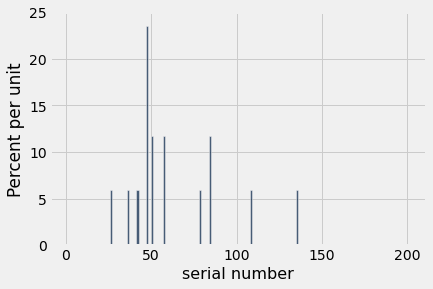

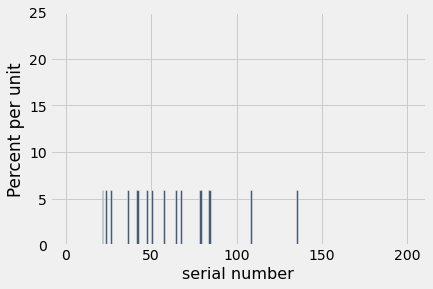

In [12]:
plot_serial_numbers(one_resample)
plot_serial_numbers(observations)

#### Question 2.3
Which of the following are true:
1. In the plot of the resample, there are no bars at locations that weren't there in the plot of the original observations.
2. In the plot of the original observations, there are no bars at locations that weren't there in the plot of the resample.
3. The resample has exactly one copy of each serial number.
4. The sample has exactly one copy of each serial number.

Assign true_statements to a list of the correct statements.

In [16]:
true_statements = [1,4]

In [17]:
_ = ok.grade('q2_3')

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



#### Question 2.4
Create 2 more resamples. For each one, plot it as well as compute the max- and mean-based estimates using that resample.

Mean-based estimate for resample 0: 128.8235294117647
Max-based estimate for resample 0: 135
Mean-based estimate for resample 1: 106.82352941176471
Max-based estimate for resample 1: 108


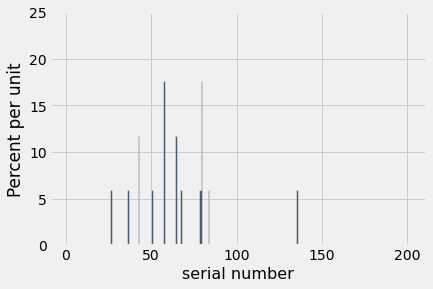

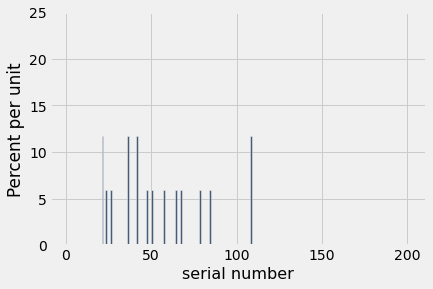

In [19]:
resample_0 = simulate_resample()
plot_serial_numbers(resample_0)

mean_based_estimate_0 = mean_based_estimator(resample_0.column("serial number"))
max_based_estimate_0 = max(resample_0.column("serial number"))
print("Mean-based estimate for resample 0:", mean_based_estimate_0)
print("Max-based estimate for resample 0:", max_based_estimate_0)

resample_1 = simulate_resample()
plot_serial_numbers(resample_1)

mean_based_estimate_1 = mean_based_estimator(resample_1.column("serial number")) 
max_based_estimate_1 = max(resample_1.column("serial number"))

print("Mean-based estimate for resample 1:", mean_based_estimate_1)
print("Max-based estimate for resample 1:", max_based_estimate_1)

You may find that the max-based estimates from the resamples are both exactly 135.  You will probably find that the two mean-based estimates do differ from the sample mean-based estimate (and from each other).

#### Question 2.5
Using probability that you've learned, compute the exact chance that a max-based estimate from *one* resample is 135.  
Using your intuition, explain why a mean-based estimate from a resample is less often exactly equal to the mean-based estimate from the original sample as compared to a max-based estimate.

The chance of getting at least one 135 is 1 - (16/17)^17 = 64%

It is less often exactly equal because in order to be exactly equal it would need to have exatly the same elements or each difference exactly balance out.

Discuss your answers with a neighbor or TA.  If you have difficulty with the probability calculation, work with someone or ask for help; don't stay stuck on it for too long.

## 3. Simulating with resampling
Since resampling from a sample looks just like sampling from a population, the code should look almost the same.  That means we can write a function that simulates either sampling from a population or resampling from a sample.  If we pass it a population as its argument, it will do the former; if we pass it a sample, it will do the latter.

#### Question 3.1
Write a function called `simulate_estimates`.  It should take 4 arguments:
1. A table from which the data should be sampled.  The table will have 1 column named `"serial number"`.
2. The size of each sample from that table, an integer.  (For example, to do resampling, we would pass for this argument the number of rows in the table.)
3. A function that computes a statistic of a sample.  This argument is a *function* that takes an array of serial numbers as its argument and returns a number.
4. The number of replications to perform.

It should simulate many samples with replacement from the given table.  (The number of samples is the 4th argument.)  For each of those samples, it should compute the statistic on that sample. Then it should return an array containing each of those statistics.  The code below provides an example use of your function and describes how you can verify that you've written it correctly.

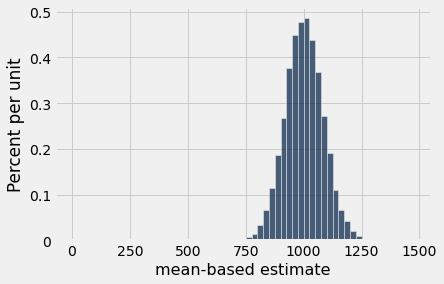

In [22]:
def simulate_estimates(original_table, sample_size, statistic, num_replications):
    # Our implementation of this function took 5 short lines of code.
    stats = make_array()
    for i in np.arange(num_replications):
        s = statistic(original_table.sample(sample_size).column("serial number"))
        stats = np.append(stats, s)
    return stats
# This should generate an empirical histogram of twice-mean estimates
# of N from samples of size 50 if N is 1000.  This should be a bell-shaped
# curve centered at 1000 with most of its mass in [800, 1200].  To verify your
# answer, make sure that's what you see!
example_estimates = simulate_estimates(
    Table().with_column("serial number", np.arange(1, 1000+1)),
    50,
    mean_based_estimator,
    10000)
Table().with_column("mean-based estimate", example_estimates).hist(bins=np.arange(0, 1500, 25))

Now we can go back to the sample we actually observed (the table `observations`) and estimate how much our mean-based estimate of `N` would have varied from sample to sample.

#### Question 3.2
Using the bootstrap and the sample `observations`, simulate the approximate distribution of *mean-based estimates* of `N`.  Use 5,000 replications.  
We have provided code that plots a histogram, allowing you to visualize the simulated estimates.

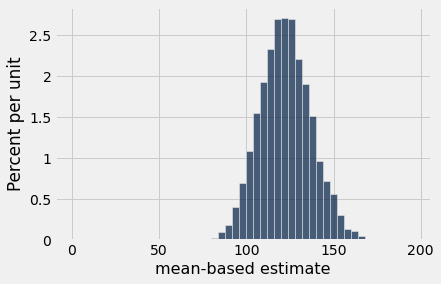

In [23]:
bootstrap_estimates = simulate_estimates(observations, num_observations, mean_based_estimator, 5000)
Table().with_column("mean-based estimate", bootstrap_estimates).hist(bins=np.arange(0, 200, 4)) 

#### Question 3.3
Compute an interval that covers the middle 95% of the bootstrap estimates.  Verify that your interval looks like it covers 95% of the area in the histogram above.

In [25]:
left_end = percentile(2.5, bootstrap_estimates)
right_end = percentile(97.5, bootstrap_estimates)
print("Middle 95% of bootstrap estimates: [{:f}, {:f}]".format(left_end, right_end))

Middle 95% of bootstrap estimates: [94.823529, 152.000000]


#### Question 3.4
Your mean-based estimate of `N` should have been around 122.  Given the above calculations, is it likely that `N` is exactly 122?  Quantify the amount of error in the estimate by making a statement like this:

> "Assuming the population looks similar to the sample, the *difference* between `N` and mean-based estimates of `N` from samples of size 17 is typically in the range [A NUMBER, ANOTHER NUMBER]."

It is not likely that N is exactly 122. It is probable that N is within 30 or 40 of it.

#### Question 3.5
`N` was actually 150!  Write code that simulates the sampling and bootstrapping process again, as follows:

1. Generate a new set of random observations the RAF might have seen by sampling from the population table we have created for you below. 
2. Compute an estimate of `N` from these new observations, using `mean_based_estimator`.
3. Using only the new observations, compute 5,000 bootstrap estimates of `N`.
4. Plot these bootstrap estimates and compute an interval covering the middle 95%.

Middle 95% of bootstrap estimates: [88.941176, 177.529412]


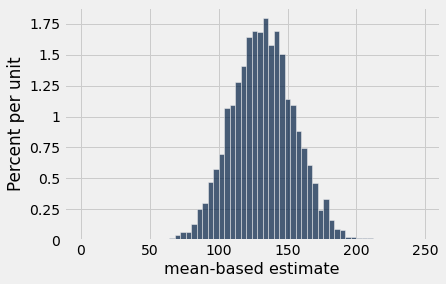

In [27]:
population = Table().with_column("serial number", np.arange(1, 150+1))

new_observations = population.sample(num_observations)
new_mean_based_estimate = mean_based_estimator(new_observations.column("serial number")) 
new_bootstrap_estimates = simulate_estimates(new_observations, num_observations, mean_based_estimator, 5000) 

Table().with_column("mean-based estimate", new_bootstrap_estimates).hist(bins=np.arange(0, 252, 4))

new_left_end =  percentile(2.5, new_bootstrap_estimates)
new_right_end  = percentile(97.5, new_bootstrap_estimates)

print("Middle 95% of bootstrap estimates: [{:f}, {:f}]".format(new_left_end, new_right_end))

#### Question 3.6
Does the interval covering the middle 95% of the new bootstrap estimates include `N`?  If you ran that cell many times, what is the probability that it will include `N`?

Yes, it does. The probability it will include N is 0.95.

In [28]:
# For your convenience, you can run this cell to run all the tests at once!
import os
_ = [ok.grade(q[:-3]) for q in os.listdir("tests") if q.startswith('q')]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



In [ ]:
_ = ok.submit()

<IPython.core.display.Javascript object>